# Bangkit Assigment: Lung Disease Classification with Machine Learning
This is an initial commit of the notebook, please add more things here!

## Dependencies

In [40]:
# Install dependencies

!pip install -q kaggle
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 3.3MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [20]:
# Import libraries

# Colab library to upload files to notebook
from google.colab import files

# Import necessary libraries for processing
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Utility
import math
import scipy.io.wavfile as wf  #wave file reader

# Feature extraction
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# CNN
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from datetime import datetime

# Results
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Setup kaggle API

In [2]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

## Data Preparation

### Download from kaggle

In [25]:
%%time
# Download dataset from upstream
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.67G/3.69G [01:34<00:00, 66.6MB/s]
100% 3.69G/3.69G [01:34<00:00, 42.0MB/s]
CPU times: user 710 ms, sys: 162 ms, total: 872 ms
Wall time: 1min 36s


In [26]:
%%time
# Unzip dataset into a folder
!unzip respiratory-sound-database.zip -d dataset

Archive:  respiratory-sound-database.zip
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_fi

### Data processing

In [0]:
df_no_diagnosis = pd.read_csv('dataset/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [0]:
# Combine diagnosis data with patient data
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [0]:
root = 'dataset/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [0]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [0]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,174,2p3,Pl,mc,AKGC417L
0,185,1b1,Ar,sc,Litt3200
0,203,1p4,Pl,mc,AKGC417L
0,147,2b3,Al,mc,AKGC417L
0,163,2b2,Pr,mc,AKGC417L


In [0]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

In [0]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]
file_label_df.sum()

filename                 174_2p3_Pl_mc_AKGC417L185_1b1_Ar_sc_Litt320020...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

### Utility Functions

In [0]:
import math
import scipy.io.wavfile as wf
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

### Distribution of respiratory cycle lengths


longest cycle:16.163
shortest cycle:0.20000000000000284
Fraction of samples less than 5 seconds:0.9660771238040011


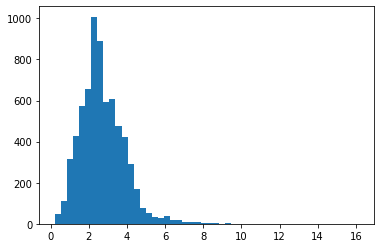

In [0]:
duration_list = []
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

## Feature Extraction



### Feature extraction function

In [0]:
max_pad_len = 862 # to make the length of all MFCC equal

#This function takes in the path for an audio file as a string, loads it, and returns the MFCC
# of the audio
def extract_features_mfcc(file_name):
    # try:
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    padding_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, padding_width)), mode='constant')
        
    # except Exception as e:
    #     print("Error encountered while parsing file: ", file_name)
    #     return None 
     
    return mfccs

In [23]:
filenames = [f for f in listdir(root) if (isfile(join(root, f)) and f.endswith('.wav'))] 
filepaths = [join(root, f) for f in filenames] # full paths of files
# features = [] 

# Iterate through each sound file and extract the features
# for file_name in filepaths:
#     data = extract_features_mfcc(file_name)
#     if data is not None:
#       # print(data)
#       features.append(data)

print('Finished feature extraction using MFCC from ', len(features), ' files')

NameError: ignored

### Data preparation

In [20]:
# patient IDs corresponding to each file
p_id_in_file = [] 
for name in filenames:
    p_id_in_file.append(int(name[:3]))

# patient diagnosis file - Should use the file in the beginning of the notebook but it returns error
p_diag = pd.read_csv('dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',header=None) 

p_id_in_file = np.array(p_id_in_file) 

# labels for audio files
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) 

# Remove a very rare disease, it returns an error if we're not removing it
labels_fix = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels_fix)
oh_labels = to_categorical(i_labels) 


NameError: ignored

In [0]:
# convert to numpy array
features = np.array(features) 

# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma' )| (labels == 'LRTI') )[0], axis=0) 

# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1))

(917, 40, 862, 1)


In [0]:
# train test split = This is the data for training the model
train_features, test_features, train_labels, test_labels = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

## Build the Model Using CNN


### Download training data from kaggle to speed up training

In [4]:
%%time
# Download processed feature extraction
!kaggle datasets download -d risyadhasbullah/bangkit-features
!unzip bangkit-features.zip -d cached
train_features = np.load('cached/train_features.npy')
test_features = np.load('cached/test_features.npy')
train_labels = np.load('cached/train_labels.npy')
test_labels = np.load('cached/test_labels.npy')
oh_labels = np.load('cached/oh_labels.npy')

 96% 220M/229M [00:02<00:00, 55.1MB/s]
100% 229M/229M [00:02<00:00, 85.0MB/s]
Archive:  bangkit-features.zip
replace cached/oh_labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
CPU times: user 97 ms, sys: 139 ms, total: 236 ms
Wall time: 10.7 s


### CNN

In [0]:
# set data size
num_rows = 40
num_columns = 862
num_channels = 1
num_labels = oh_labels.shape[1]

# hyperparameters
filter_size = 2

In [0]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [7]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(test_features, test_labels, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 430, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 213, 64)       

In [0]:
# hyperparameters
num_epochs = 200
num_batch_size = 128

In [0]:
# train model
callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(train_features, train_labels, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(test_features, test_labels), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 733 samples, validate on 184 samples
Epoch 1/200
733/733 [==============================] - 9s 12ms/step - loss: 0.0952 - accuracy: 0.9550 - val_loss: 0.4079 - val_accuracy: 0.9239

Epoch 00001: val_accuracy improved from -inf to 0.92391, saving model to mymodel2_01.h5
Epoch 2/200
733/733 [==============================] - 9s 12ms/step - loss: 0.0865 - accuracy: 0.9659 - val_loss: 0.4495 - val_accuracy: 0.9076

Epoch 00002: val_accuracy did not improve from 0.92391
Epoch 3/200
733/733 [==============================] - 9s 12ms/step - loss: 0.0807 - accuracy: 0.9782 - val_loss: 0.4389 - val_accuracy: 0.9130

Epoch 00003: val_accuracy did not improve from 0.92391
Epoch 4/200
733/733 [==============================] - 9s 12ms/step - loss: 0.0790 - accuracy: 0.9727 - val_loss: 0.4720 - val_accuracy: 0.9076

Epoch 00004: val_accuracy did not improve from 0.92391
Epoch 5/200
733/733 [==============================] - 9s 12ms/step - loss: 0.0863 - accuracy: 0.9741 - val_loss: 0.4646 

In [11]:
# Evaluating the model on the training and testing set
score = model.evaluate(train_features, train_labels, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(test_features, test_labels, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9208731055259705
Testing Accuracy:  0.9021739363670349


In [0]:
preds = model.predict(test_features) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(test_labels, axis=1) # true classes

n_classes=6 # number of classes

In [0]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [0]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

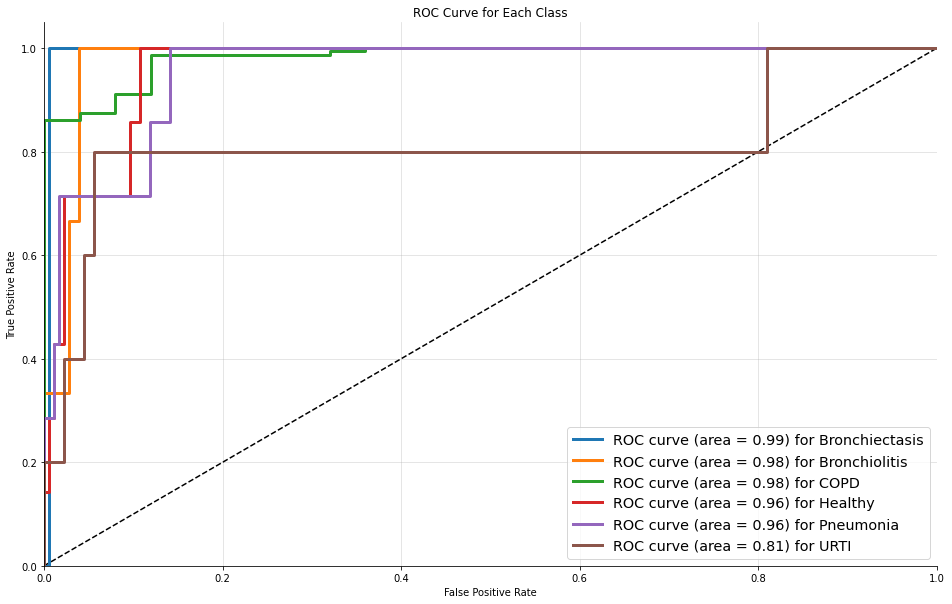

In [21]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [26]:
print('Classification Report')
print(classification_report(y_testclass, classpreds, target_names=c_names))


print('Confusion Matrix')
print(confusion_matrix(y_testclass, classpreds))

Classification Report
                precision    recall  f1-score   support

Bronchiectasis       0.67      0.67      0.67         3
 Bronchiolitis       1.00      0.33      0.50         3
          COPD       0.92      1.00      0.96       159
       Healthy       1.00      0.14      0.25         7
     Pneumonia       1.00      0.29      0.44         7
          URTI       0.25      0.20      0.22         5

      accuracy                           0.90       184
     macro avg       0.81      0.44      0.51       184
  weighted avg       0.90      0.90      0.88       184

Confusion Matrix
[[  2   0   1   0   0   0]
 [  0   1   2   0   0   0]
 [  0   0 159   0   0   0]
 [  0   0   4   1   0   2]
 [  0   0   4   0   2   1]
 [  1   0   3   0   0   1]]
